In [1]:
from google.colab import drive
import os

# Perintah ini akan memunculkan jendela pop-up untuk meminta izin
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset-Skripsi'
dataset_dir = os.path.join(base_dir, 'Dataset')
output_dir = os.path.join(base_dir, 'Output')

# Membuat folder jika belum ada
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

print("Google Drive terhubung dan folder siap.")
print(f"Folder Dataset: {dataset_dir}")
print(f"Folder Output: {output_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive terhubung dan folder siap.
Folder Dataset: /content/drive/MyDrive/Dataset-Skripsi/Dataset
Folder Output: /content/drive/MyDrive/Dataset-Skripsi/Output


In [2]:
# Install MTCNN untuk deteksi wajah
!pip install mtcnn

In [3]:
# Untuk Deep Learning (TensorFlow & Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Untuk Pengolahan Angka dan Gambar
import numpy as np
import cv2  # Ini adalah OpenCV
import matplotlib.pyplot as plt

# Untuk Utilitas Sistem dan File
import os
import glob
import random

# Untuk Deteksi Wajah (yang baru kita install)
from mtcnn.mtcnn import MTCNN

# Untuk Evaluasi Model
from sklearn.metrics import classification_report, confusion_matrix

print("Semua library dasar berhasil di-impor.")

Semua library dasar berhasil di-impor.


In [4]:
# Tentukan path output Anda (sudah didefinisikan di sel 1, tapi kita definisikan lagi di sini untuk jelas)
output_dir = '/content/drive/MyDrive/Dataset-Skripsi/Output'

# Tentukan path untuk train, validation, dan test
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

print("Struktur folder train/validation/test telah dibuat di dalam Output.")

Struktur folder train/validation/test telah dibuat di dalam Output.


In [5]:
# Inisialisasi detektor MTCNN
detector = MTCNN()
print("Detektor MTCNN siap digunakan.")

Detektor MTCNN siap digunakan.


In [6]:
import cv2
import os
from mtcnn.mtcnn import MTCNN
import glob

# Inisialisasi detektor lagi (untuk memastikan, jika sel terpisah)
try:
    detector
except NameError:
    detector = MTCNN()

# Path dari sel 1
dataset_dir = '/content/drive/MyDrive/Dataset-Skripsi/Dataset'
output_dir = '/content/drive/MyDrive/Dataset-Skripsi/Output'

# Tentukan berapa frame yang ingin Anda ambil per video
# Mengambil 20 frame akan memberi Anda 20 gambar wajah per video.
# Sesuaikan angka ini berdasarkan ukuran dataset Anda.
FRAMES_PER_VIDEO = 20

def extract_faces_from_video(video_path, output_folder, frames_to_extract):
    """Membaca video, mengekstrak N frame, mendeteksi wajah, dan menyimpannya."""
    video_capture = cv2.VideoCapture(video_path)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # Jika video tidak bisa dibuka
    if not video_capture.isOpened():
        print(f"Error: Tidak bisa membuka video {video_path}")
        return

    # Hitung interval frame yang akan diambil
    if total_frames <= 0:
        print(f"Error: Video {video_path} tidak memiliki frame.")
        return

    frame_interval = max(1, total_frames // frames_to_extract)

    frame_count = 0
    saved_face_count = 0

    while frame_count < total_frames and saved_face_count < frames_to_extract:
        # Set video ke frame yang diinginkan
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        success, frame = video_capture.read()

        if not success:
            frame_count += frame_interval # Lompat ke frame selanjutnya jika gagal baca
            continue

        # Konversi frame BGR (OpenCV) ke RGB (MTCNN)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Deteksi wajah
        faces = detector.detect_faces(frame_rgb)

        if faces:
            # Ambil wajah pertama (biasanya yang paling besar/paling jelas)
            face_data = faces[0]
            x, y, w, h = face_data['box']

            # Pastikan koordinat tidak negatif (beberapa bug di MTCNN)
            x, y = max(0, x), max(0, y)

            # Potong (crop) wajah dari frame ASLI (BGR)
            face_image = frame[y:y+h, x:x+w]

            # Simpan gambar wajah
            # Resize wajah ke ukuran standar, misal 224x224 (untuk model CNN nanti)
            face_image_resized = cv2.resize(face_image, (224, 224))

            # Buat nama file yang unik
            video_name = os.path.basename(video_path).split('.')[0]
            output_filename = os.path.join(output_folder, f"{video_name}_frame_{frame_count}_face_{saved_face_count}.jpg")

            cv2.imwrite(output_filename, face_image_resized)
            saved_face_count += 1

        # Lompat ke interval frame selanjutnya
        frame_count += frame_interval

    video_capture.release()
    # print(f"Selesai memproses {video_path}. Total wajah disimpan: {saved_face_count}")

print("Fungsi extract_faces_from_video() telah didefinisikan.")

Fungsi extract_faces_from_video() telah didefinisikan.


In [7]:
import random
import os # Pastikan os sudah diimpor, yang sudah ada di sel awal

# Tentukan rasio pembagian data
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Path folder output (dari sel 4)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

# Path folder input (Dataset)
real_videos_path = os.path.join(dataset_dir, 'Celeb-real')
fake_videos_path = os.path.join(dataset_dir, 'Celeb-synthesis')

# Loop untuk REAL dan FAKE
for (video_type, source_path) in [("Celeb-real", real_videos_path), ("Celeb-synthesis", fake_videos_path)]:
    print(f"\nMemulai memproses video kategori: {video_type}...")

    # Ambil semua file video (misal .mp4)
    video_files = glob.glob(os.path.join(source_path, "*.mp4"))

    if not video_files:
        print(f"PERINGATAN: Tidak ada file .mp4 ditemukan di {source_path}")
        continue

    random.shuffle(video_files) # Acak urutan video

    # Hitung jumlah data untuk tiap set
    total_videos = len(video_files)
    train_count = int(total_videos * TRAIN_RATIO)
    val_count = int(total_videos * VAL_RATIO)

    # Bagi daftar video
    train_videos = video_files[:train_count]
    val_videos = video_files[train_count : train_count + val_count]
    test_videos = video_files[train_count + val_count:]

    print(f"Total video {video_type}: {total_videos}")
    print(f"Data latih (train): {len(train_videos)} video")
    print(f"Data validasi (val): {len(val_videos)} video")
    print(f"Data uji (test): {len(test_videos)} video")

    # Proses dan simpan ke folder yang sesuai
    # 1. Proses TRAIN
    print(f"Memproses {video_type} untuk TRAIN...")
    output_folder_train = os.path.join(train_dir, video_type)
    os.makedirs(output_folder_train, exist_ok=True) # Tambahkan ini untuk membuat folder kelas
    for video_file in train_videos:
        extract_faces_from_video(video_file, output_folder_train, FRAMES_PER_VIDEO)

    # 2. Proses VALIDATION
    print(f"Memproses {video_type} untuk VALIDATION...")
    output_folder_val = os.path.join(val_dir, video_type)
    os.makedirs(output_folder_val, exist_ok=True) # Tambahkan ini untuk membuat folder kelas
    for video_file in val_videos:
        extract_faces_from_video(video_file, output_folder_val, FRAMES_PER_VIDEO)

    # 3. Proses TEST
    print(f"Memproses {video_type} untuk TEST...")
    output_folder_test = os.path.join(test_dir, video_type)
    os.makedirs(output_folder_test, exist_ok=True) # Tambahkan ini untuk membuat folder kelas
    for video_file in test_videos:
        extract_faces_from_video(video_file, output_folder_test, FRAMES_PER_VIDEO)

print("\n--- PROSES EKSTRAKSI SELESAI ---")


Memulai memproses video kategori: Celeb-real...
Total video Celeb-real: 309
Data latih (train): 216 video
Data validasi (val): 46 video
Data uji (test): 47 video
Memproses Celeb-real untuk TRAIN...
Memproses Celeb-real untuk VALIDATION...
Memproses Celeb-real untuk TEST...

Memulai memproses video kategori: Celeb-synthesis...
Total video Celeb-synthesis: 305
Data latih (train): 213 video
Data validasi (val): 45 video
Data uji (test): 47 video
Memproses Celeb-synthesis untuk TRAIN...
Memproses Celeb-synthesis untuk VALIDATION...
Memproses Celeb-synthesis untuk TEST...

--- PROSES EKSTRAKSI SELESAI ---


In [8]:
# Tentukan path dari Fase 1
output_dir = '/content/drive/MyDrive/Dataset-Skripsi/Output'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

# Tentukan parameter gambar
# Ukuran ini HARUS SAMA dengan yang Anda gunakan di Fase 1 (224x224)
IMG_SIZE = 224
BATCH_SIZE = 32 # Berapa gambar yang dimuat sekaligus

# 1. Generator untuk Data Latih (dengan Augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi piksel dari 0-255 ke 0-1
    rotation_range=20,          # Putar gambar secara acak
    width_shift_range=0.2,      # Geser horizontal
    height_shift_range=0.2,     # Geser vertikal
    shear_range=0.2,            # Miringkan gambar
    zoom_range=0.2,             # Zoom gambar
    horizontal_flip=True,       # Balik gambar secara horizontal
    fill_mode='nearest'
)

# 2. Generator untuk Data Validasi & Tes (TANPA Augmentasi, hanya rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Buat 'Pipa' yang membaca dari folder
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary' # Karena kita punya 2 kelas: REAL vs FAKE
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Tidak perlu diacak untuk validasi
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Tidak perlu diacak untuk tes
)

print(f"Kelas ditemukan: {train_generator.class_indices}")

Found 12261 images belonging to 4 classes.
Found 7061 images belonging to 4 classes.
Found 7521 images belonging to 4 classes.
Kelas ditemukan: {'Celeb-real': 0, 'Celeb-synthesis': 1, 'FAKE': 2, 'REAL': 3}


In [9]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Tentukan ukuran input
input_shape = (IMG_SIZE, IMG_SIZE, 3)

# 1. Muat Model Dasar (XceptionNet)
# include_top=False berarti kita tidak menyertakan lapisan klasifikasi aslinya
# weights='imagenet' berarti kita memuat bobot yang sudah terlatih
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# 2. Bekukan lapisan dasar
# Kita tidak ingin melatih ulang lapisan yang sudah pintar ini (untuk saat ini)
base_model_xception.trainable = False

# 3. Tambahkan 'Kepala' (Head) baru kita di atas model dasar
x = base_model_xception.output
x = GlobalAveragePooling2D()(x) # Meratakan output fitur
x = Dense(1024, activation='relu')(x) # Lapisan tersembunyi (hidden layer)
x = Dropout(0.5)(x) # Mencegah overfitting
# Lapisan output: 1 neuron dengan aktivasi sigmoid (menghasilkan angka 0-1)
predictions = Dense(1, activation='sigmoid')(x)

# 4. Gabungkan menjadi model akhir
model_xception = Model(inputs=base_model_xception.input, outputs=predictions)

# 5. Kompilasi Model
# Kita gunakan 'binary_crossentropy' karena ini masalah 2 kelas (REAL vs FAKE)
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Gunakan learning rate kecil
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model_xception.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [10]:
# Tentukan berapa epoch (putaran) Anda ingin melatih
EPOCHS = 5 # Mulai dengan 10, Anda bisa tambah nanti

# Hitung jumlah langkah per epoch
# Ini penting agar Keras tahu berapa banyak batch yang harus diambil
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Total langkah per epoch (train): {steps_per_epoch}")
print(f"Total langkah validasi: {validation_steps}")

# Mulai pelatihan!
history_xception = model_xception.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

print("\n--- PELATIHAN XCEPTIONNET SELESAI ---")

Total langkah per epoch (train): 383
Total langkah validasi: 220


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 5193s 14s/step - accuracy: 0.6430 - loss: 0.6229 - val_accuracy: 0.7709 - val_loss: 0.4993
Epoch 2/5
  1/383 ━━━━━━━━━━━━━━━━━━━━ 44:46 7s/step - accuracy: 0.7500 - loss: 0.4713

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


383/383 ━━━━━━━━━━━━━━━━━━━━ 1795s 5s/step - accuracy: 0.7500 - loss: 0.4713 - val_accuracy: 0.7605 - val_loss: 0.5033
Epoch 3/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 5026s 13s/step - accuracy: 0.7667 - loss: 0.4935 - val_accuracy: 0.7859 - val_loss: 0.4577
Epoch 4/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 1765s 5s/step - accuracy: 0.8438 - loss: 0.4424 - val_accuracy: 0.7972 - val_loss: 0.4487
Epoch 5/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 4986s 13s/step - accuracy: 0.7781 - loss: 0.4639 - val_accuracy: 0.8636 - val_loss: 0.3842

--- PELATIHAN XCEPTIONNET SELESAI ---


Model XceptionNet disimpan di: /content/drive/MyDrive/Dataset-Skripsi/Output/model_xception_final.h5
Riwayat pelatihan disimpan di: /content/drive/MyDrive/Dataset-Skripsi/Output/history_xception.pkl


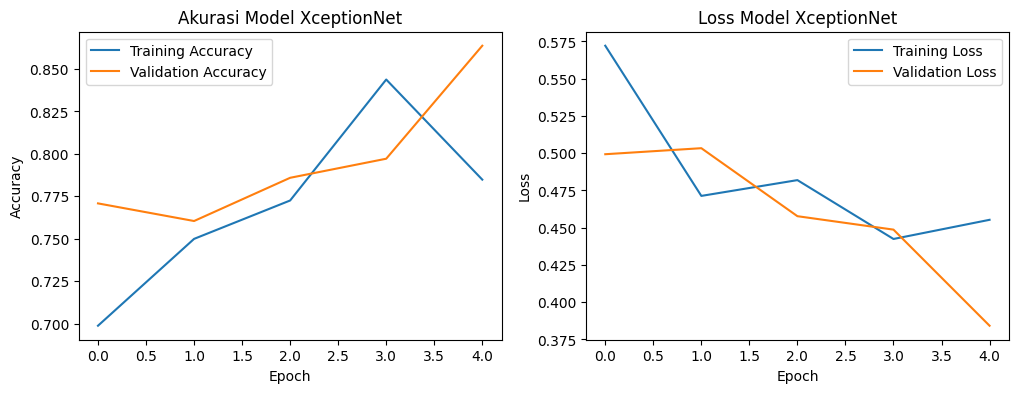

In [11]:
# Simpan model yang sudah dilatih
model_path_xception = os.path.join(output_dir, 'model_xception_final.h5')
model_xception.save(model_path_xception)
print(f"Model XceptionNet disimpan di: {model_path_xception}")

# Simpan riwayat pelatihan (untuk dibuat grafik nanti)
import pickle # Pickle digunakan untuk menyimpan objek Python

history_path_xception = os.path.join(output_dir, 'history_xception.pkl')
with open(history_path_xception, 'wb') as f:
    pickle.dump(history_xception.history, f)

print(f"Riwayat pelatihan disimpan di: {history_path_xception}")

# --- (OPSIONAL) Plot Grafik Pelatihan ---
plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Training Accuracy')
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model XceptionNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Training Loss')
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.title('Loss Model XceptionNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
from tensorflow.keras.applications import MobileNetV2

# 1. Muat Model Dasar (MobileNetV2)
# Kita gunakan input_shape yang sama (224x224x3)
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# 2. Bekukan lapisan dasar
base_model_mobilenet.trainable = False

# 3. Tambahkan 'Kepala' (Head) baru
# Strukturnya kita buat sama persis dengan XceptionNet untuk perbandingan yang adil
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# 4. Gabungkan menjadi model akhir
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)

# 5. Kompilasi Model
# Gunakan optimizer dan loss yang sama persis untuk perbandingan yang adil
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Tentukan epoch (samakan dengan XceptionNet untuk perbandingan awal)
EPOCHS = 5

# Ambil langkah dari sel 10 (seharusnya sudah ada di memori)
# steps_per_epoch = train_generator.samples // BATCH_SIZE
# validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Memulai pelatihan MobileNetV2...")
print(f"Total langkah per epoch (train): {steps_per_epoch}")
print(f"Total langkah validasi: {validation_steps}")

# Mulai pelatihan!
history_mobilenet = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

print("\n--- PELATIHAN MOBILENETV2 SELESAI ---")

Memulai pelatihan MobileNetV2...
Total langkah per epoch (train): 383
Total langkah validasi: 220
Epoch 1/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 1136s 3s/step - accuracy: 0.6536 - loss: 0.6158 - val_accuracy: 0.8178 - val_loss: 0.4272
Epoch 2/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 347s 905ms/step - accuracy: 0.9062 - loss: 0.3820 - val_accuracy: 0.8169 - val_loss: 0.4266
Epoch 3/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 1186s 3s/step - accuracy: 0.7731 - loss: 0.4697 - val_accuracy: 0.8418 - val_loss: 0.3793
Epoch 4/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 377s 984ms/step - accuracy: 0.8438 - loss: 0.3855 - val_accuracy: 0.8430 - val_loss: 0.3793
Epoch 5/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 1117s 3s/step - accuracy: 0.7982 - loss: 0.4306 - val_accuracy: 0.8449 - val_loss: 0.3660

--- PELATIHAN MOBILENETV2 SELESAI ---


Model MobileNetV2 disimpan di: /content/drive/MyDrive/Dataset-Skripsi/Output/model_mobilenet_final.h5
Riwayat pelatihan disimpan di: /content/drive/MyDrive/Dataset-Skripsi/Output/history_mobilenet.pkl


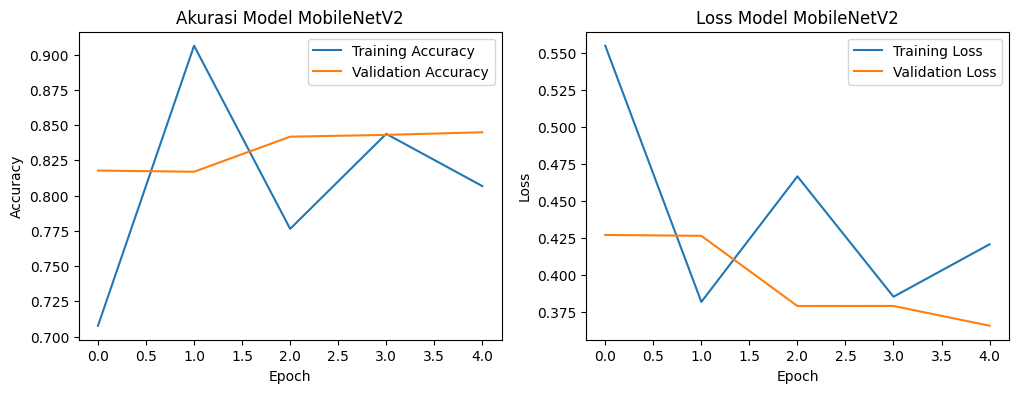

In [14]:
# Simpan model yang sudah dilatih
model_path_mobilenet = os.path.join(output_dir, 'model_mobilenet_final.h5')
model_mobilenet.save(model_path_mobilenet)
print(f"Model MobileNetV2 disimpan di: {model_path_mobilenet}")

# Simpan riwayat pelatihan (untuk dibuat grafik nanti)
history_path_mobilenet = os.path.join(output_dir, 'history_mobilenet.pkl')
with open(history_path_mobilenet, 'wb') as f:
    pickle.dump(history_mobilenet.history, f)

print(f"Riwayat pelatihan disimpan di: {history_path_mobilenet}")

# --- Plot Grafik Pelatihan ---
plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('Loss Model MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()